In [1]:
using Images
using ImageTransformations
using Interpolations
using LinearAlgebra
using Random, Distributions, StatsBase, Plots
rngSeed = Random.seed!(0)
dirFile = "/home/javiersc/Desktop/CroppedYale/yaleB28/"
f = open(string(dirFile,"yaleB28_P00.info"));
lines = readlines(f);
scaleFactor = 3
dataMatrix = zeros(round(Int,192*168/(scaleFactor^2)),length(lines))
i = 1
for l in lines
        img = load(string(dirFile, l))
        img = convert(Array{Float64}, img)
        σ = map((o,n) -> 0.75*o/n, size(img), ceil.(Int, size(img).*(1/scaleFactor)) )
        kern = KernelFactors.gaussian(σ)
        #img = imresize(imfilter(img,kern,NA()), ratio=1/scaleFactor, method=BSpline(Linear()))
        img = imresize(img, ratio=1/scaleFactor, method=BSpline(Linear()))
        dataMatrix[:,i] = vec(img)
        i += 1
end
D, N = size(dataMatrix)
permutationOrder = randperm(Random.seed!(0), N)
dataMatrix = dataMatrix[:,permutationOrder]
 # David's SignFlip PA
σfs = [svdvals(rand([-1,1],size(dataMatrix)) .* dataMatrix) for _ in 1:5]
σfs = [getindex.(σfs,j) for j in 1:min(D,N)]
α = 0.95
rank = findfirst(svdvals(dataMatrix) .<= quantile.(σfs,α)) - 1
U = svd(dataMatrix).U[:,1:rank];

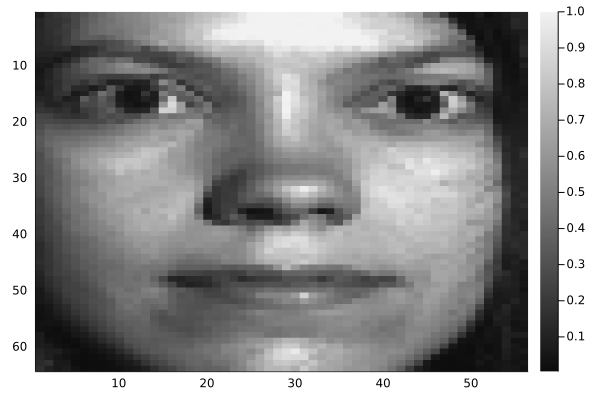

In [2]:
originalImage = reshape(dataMatrix[:,15],(round(Int,192/scaleFactor),round(Int,168/scaleFactor)))
heatmap(originalImage, yflip=true, c=:grays)
#savefig("FACES_EXAMPLE_IMAGE.pdf")

In [3]:
size(originalImage)

(64, 56)

In [112]:
using MAT
file = matopen("/home/javiersc/Desktop/heavyBlur.mat")
heavyBlur = read(file, "newMatrixHeavy") # note that this does NOT introduce a variable ``varname`` into scope
close(file)

file = matopen("/home/javiersc/Desktop/lightBlur.mat")
lightBlur = read(file, "newMatrixLight") # note that this does NOT introduce a variable ``varname`` into scope
close(file)

In [113]:
goodSamples = 4

function op(dataMatrix, goodSamples)
    output1 = heavyBlur*dataMatrix[:,(goodSamples+1):end] 
    output2 = lightBlur*dataMatrix[:,1:goodSamples] 
    output = hcat(output2,output1)
    return output
end


function adjoint_op(dataMatrix, goodSamples)
    output1 = heavyBlur'*dataMatrix[:,(goodSamples+1):end] 
    output2 = lightBlur'*dataMatrix[:,1:goodSamples] 
    output = hcat(output2,output1)
    return output
end

function generateData(dataMatrix, goodSamples)
    rngSeed = Random.seed!(0)
    output1 = heavyBlur*dataMatrix[:,(goodSamples+1):end] 
    output2 = lightBlur*dataMatrix[:,1:goodSamples]
    output = hcat(output2,output1)
    output = output + rand(Normal(0,0.01), size(output))
    return output
end


generateData (generic function with 1 method)

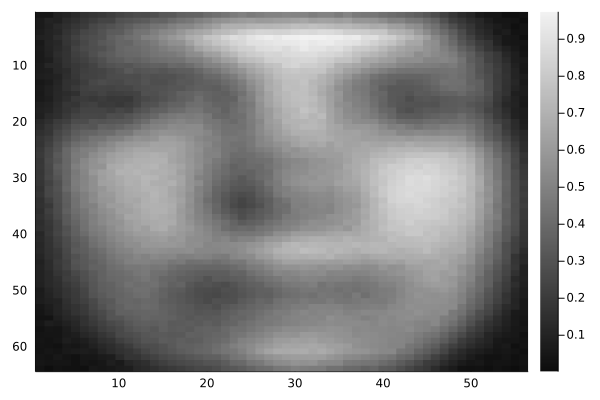

In [114]:
Y = generateData(dataMatrix, goodSamples);
noisyImage = reshape(Y[:,15] ,(round(Int,192/scaleFactor),round(Int,168/scaleFactor)) ) ;
heatmap(noisyImage, yflip=true, c=:grays)
#savefig("FACES_HIGH_BLURRY.pdf")

In [115]:
include("pogm_restart.jl")
function HPCA_POGM(Y, λr, N, bound, goodSamples)
    Lf = 1*max((opnorm(Array(lightBlur),2)), (opnorm(Array(heavyBlur),2)))^2
    x0 = zeros(size(Y)) #deepcopy(Y) #zeros(size(Y))
    grad = K -> -1*adjoint_op((Y-op(K, goodSamples)), goodSamples)
    soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
    function pssvt(x,t,N)
        U,S,V = svd(x)
        S[(N+1):end] = soft.(S[(N+1):end],t)
        return U*Diagonal(S)*V'
    end
    prox1 = (z,c) -> pssvt(z, c*λr, N)
    T, _ = pogm_restart(x0, x -> 0, grad, Lf ; g_prox=prox1, eps=bound, mom=:fpgm, restart=:gr) #pogm_restart(x0, x -> 0, grad, Lf ; g_prox=prox1, eps=bound, mom=:fpgm, restart=:gr)
    return T
end

HPCA_POGM (generic function with 1 method)

In [128]:
X_HPCA = HPCA_POGM(Y, 0.1, 0, 1e-3, goodSamples);

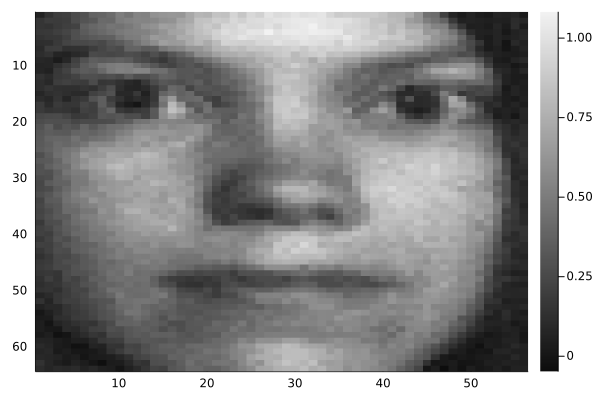

In [129]:
hpcaImage = reshape(X_HPCA[:,15],(round(Int,192/scaleFactor),round(Int,168/scaleFactor)) ) ;
heatmap(hpcaImage, yflip=true, c=:grays)
#savefig("FACES_RECONSTRUCTED.pdf")

In [130]:
using ImageQualityIndexes
assess_psnr(hpcaImage, originalImage)

26.424415246279555

In [119]:
assess_psnr(noisyImage, originalImage)

18.937362593228464

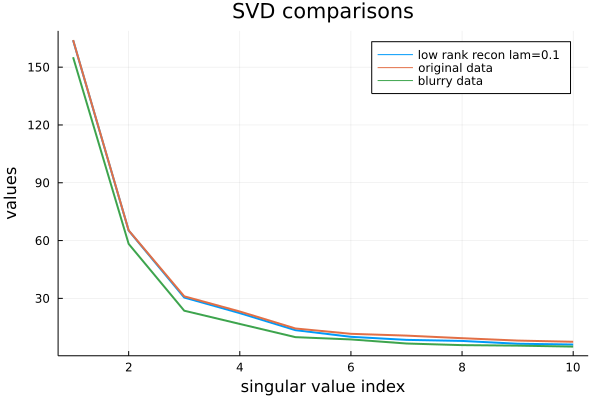

In [78]:
plot(svd(X_HPCA).S[1:10], label="low rank recon lam=0.1", linewidth=2)
plot!(svd(dataMatrix).S[1:10], label="original data", linewidth=2)
plot!(svd(Y).S[1:10], label="blurry data", linewidth=2)
plot!(xlabel="singular value index", ylabel="values", title="SVD comparisons")

In [121]:
U_test = svd(dataMatrix[:,1:goodSamples]).U[:,1:4]
denoisedMatrix = U_test*U_test'*Y
denoisedImage = reshape(denoisedMatrix[:,15],(round(Int,192/scaleFactor),round(Int,168/scaleFactor)) ) ;

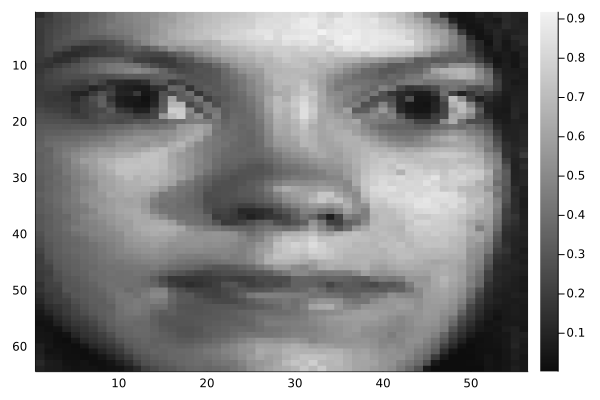

In [122]:
heatmap(denoisedImage, yflip=true, c=:grays)

In [124]:
assess_psnr(denoisedImage, originalImage)

21.03301221432204